In [1]:
import torch
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.explain import Explanation
from torch_geometric.visualization import visualize_graph
from torch_geometric.datasets import TUDataset
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,global_mean_pool

from torch_geometric.loader import DataLoader

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
def visualize(graph):
    pyg.visualization.visualize_graph(graph.edge_index)
def nx_vis(graph):
    color_map = {
    (1, 0, 0): "red",
    (0, 1, 0): "green",
    (0, 0, 1): "blue",
    }
    g = pyg.utils.to_networkx(graph, to_undirected=True)
    
    node_color = [ color_map[tuple(graph.x[i].tolist())] for i in g ]
    
    nx.draw(g, node_color = node_color)

In [9]:
dataset = TUDataset(root='./data', name='PROTEINS')

In [55]:
class GCN(torch.nn.Module):
    def __init__(self, layer_sizes, dropout=0.5):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        #self.dropout = dropout

        for i in range(len(layer_sizes) - 1):
            self.convs.append(GCNConv(layer_sizes[i], layer_sizes[i + 1]))

        self.fc = torch.nn.Linear(layer_sizes[-1], 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #edge_index, _ = dropout_edge(edge_index, p=0.2)  # Dropout edges

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            #x = F.dropout(x, p=self.dropout, training=self.training)
            
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x.squeeze()

    @torch.no_grad()
    def cosine_forward(self, data):
        self.eval()
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #edge_index, _ = dropout_edge(edge_index, p=0.2)  # Dropout edges
        cosine_history = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            cosine_history.append(self.pairwise_cosine_similarity(x))
            #x = F.dropout(x, p=self.dropout, training=self.training)
            
        return cosine_history

    def pairwise_cosine_similarity(self, x, samples=1000):
        x = F.normalize(x, p=2, dim=1)
        n = x.shape[0]
        sampled_indices = torch.randperm(n)[:samples]
        x_sampled = x[sampled_indices]
        cos_sim_matrix = torch.mm(x_sampled, x_sampled.T)
        return cos_sim_matrix.mean().item()

In [13]:
def train(model):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # Get logits
        #print(out)
        #print(data.y.float().squeeze())
        loss = criterion(out, data.y.float().squeeze())  # Compute loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    train_loss = total_loss / len(train_loader)
    val_loss = evaluate(model)
    return train_loss, val_loss

In [15]:
@torch.no_grad()
def evaluate(model):
    model.eval()
    total_loss = 0

    for data in val_loader:  # Assuming val_loader is your validation dataset
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y.float().squeeze())
        total_loss += loss.item()

    return total_loss / len(val_loader)  # Average validation loss

In [17]:
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = (out > 0).float()  # Convert logits to binary (0 or 1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total

In [19]:
def train_model(model):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    for epoch in range(100):
        train_loss, val_loss = train(model)
        train_acc = test(model, train_loader)
        val_acc = test(model, val_loader)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        #scheduler.step()
        print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [21]:
node_features = dataset.num_node_features
layers = [dataset.num_node_features, 256]
layer1 = [node_features, 64] # 1
layer2 = [node_features, 64, 64, 64, 64, 64] # 5

layer3 = [node_features, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64] # 10
layer4 = [node_features, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64 ,64, 64, 64, 64] # 15

In [25]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size



train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, shuffle=True, batch_size = 32)
val_loader = DataLoader(val_set,  batch_size = 32)
test_loader = DataLoader(test_set,  batch_size = 32)

In [23]:
model1 = GCN(layer1).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_loss1, val_loss1, train_acc1, val_acc1 = train_model(model1)

Epoch 01 | Train Loss: 0.6781 | Val Loss: 0.6791 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 02 | Train Loss: 0.6675 | Val Loss: 0.6715 | Train Acc: 0.6551 | Val Acc: 0.6036


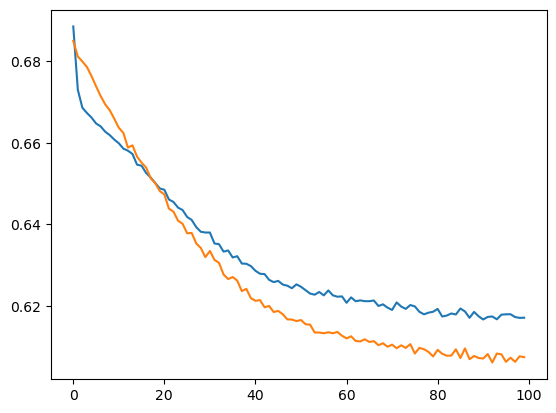

In [179]:
plt.plot(train_loss1)
plt.plot(val_loss1)

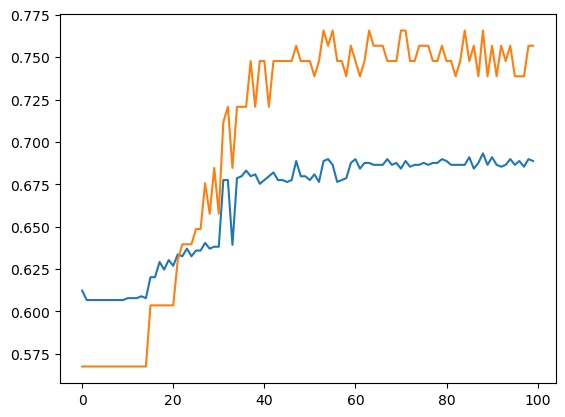

In [180]:
plt.plot(train_acc1)
plt.plot(val_acc1)

In [181]:
model2 = GCN(layer2).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = torch.nn.BCEWithLogitsLoss()

In [182]:
train_loss2, val_loss2, train_acc2, val_acc2 = train_model(model2)

Epoch 01 | Train Loss: 0.6835 | Val Loss: 0.6837 | Train Acc: 0.6067 | Val Acc: 0.5676
Epoch 02 | Train Loss: 0.6675 | Val Loss: 0.6756 | Train Acc: 0.6067 | Val Acc: 0.5676
Epoch 03 | Train Loss: 0.6658 | Val Loss: 0.6619 | Train Acc: 0.6067 | Val Acc: 0.5676
Epoch 04 | Train Loss: 0.6566 | Val Loss: 0.6457 | Train Acc: 0.6270 | Val Acc: 0.6126
Epoch 05 | Train Loss: 0.6395 | Val Loss: 0.6342 | Train Acc: 0.6292 | Val Acc: 0.6126
Epoch 06 | Train Loss: 0.6359 | Val Loss: 0.6016 | Train Acc: 0.7067 | Val Acc: 0.7838
Epoch 07 | Train Loss: 0.6242 | Val Loss: 0.5988 | Train Acc: 0.7067 | Val Acc: 0.7658
Epoch 08 | Train Loss: 0.6178 | Val Loss: 0.5938 | Train Acc: 0.6978 | Val Acc: 0.7117
Epoch 09 | Train Loss: 0.6095 | Val Loss: 0.5798 | Train Acc: 0.7169 | Val Acc: 0.8018
Epoch 10 | Train Loss: 0.6043 | Val Loss: 0.5847 | Train Acc: 0.7034 | Val Acc: 0.7748
Epoch 11 | Train Loss: 0.6049 | Val Loss: 0.5814 | Train Acc: 0.7045 | Val Acc: 0.7207
Epoch 12 | Train Loss: 0.6085 | Val Loss: 0

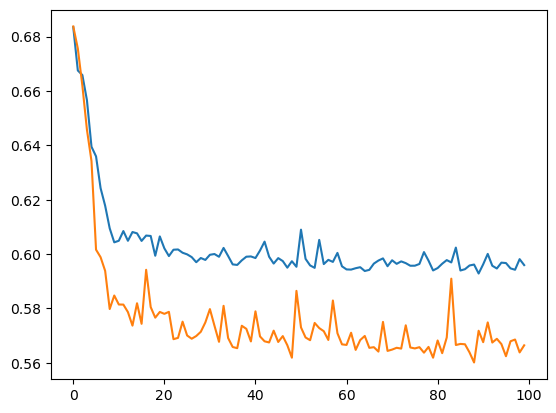

In [183]:
plt.plot(train_loss2)
plt.plot(val_loss2)

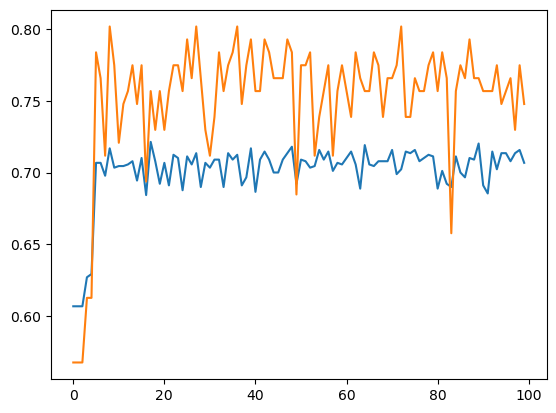

In [184]:
plt.plot(train_acc2)
plt.plot(val_acc2)

In [185]:
model3 = GCN(layer3).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = torch.nn.BCEWithLogitsLoss()

In [186]:
train_loss3, val_loss3, train_acc3, val_acc3 = train_model(model3)

Epoch 01 | Train Loss: 0.6773 | Val Loss: 0.6814 | Train Acc: 0.6067 | Val Acc: 0.5676
Epoch 02 | Train Loss: 0.6655 | Val Loss: 0.6684 | Train Acc: 0.6067 | Val Acc: 0.5676
Epoch 03 | Train Loss: 0.6592 | Val Loss: 0.6506 | Train Acc: 0.6067 | Val Acc: 0.5676
Epoch 04 | Train Loss: 0.6387 | Val Loss: 0.6543 | Train Acc: 0.6067 | Val Acc: 0.5676
Epoch 05 | Train Loss: 0.6431 | Val Loss: 0.6366 | Train Acc: 0.6640 | Val Acc: 0.7027
Epoch 06 | Train Loss: 0.6211 | Val Loss: 0.6115 | Train Acc: 0.6674 | Val Acc: 0.7387
Epoch 07 | Train Loss: 0.6092 | Val Loss: 0.5698 | Train Acc: 0.7169 | Val Acc: 0.7838
Epoch 08 | Train Loss: 0.6058 | Val Loss: 0.5910 | Train Acc: 0.6854 | Val Acc: 0.6847
Epoch 09 | Train Loss: 0.6186 | Val Loss: 0.5980 | Train Acc: 0.7090 | Val Acc: 0.7568
Epoch 10 | Train Loss: 0.6183 | Val Loss: 0.5865 | Train Acc: 0.7067 | Val Acc: 0.7477
Epoch 11 | Train Loss: 0.6070 | Val Loss: 0.6248 | Train Acc: 0.6393 | Val Acc: 0.6937
Epoch 12 | Train Loss: 0.6156 | Val Loss: 0

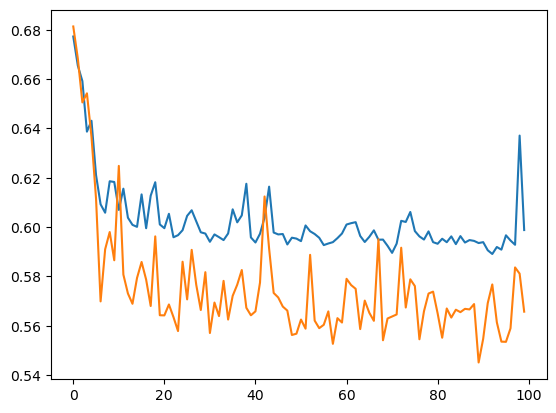

In [191]:
plt.plot(train_loss3)
plt.plot(val_loss3)

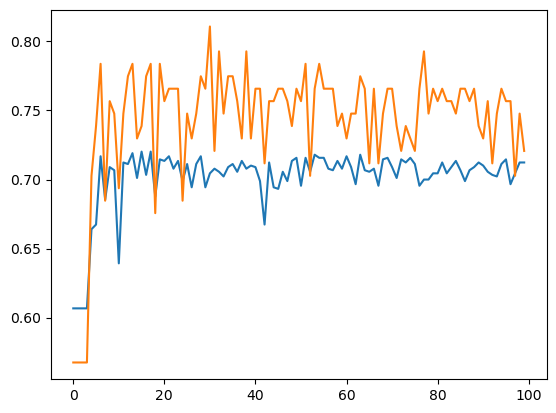

In [192]:
plt.plot(train_acc3)
plt.plot(val_acc3)

In [27]:
model4 = GCN(layer4).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=0.001, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = torch.nn.BCEWithLogitsLoss()

In [29]:
train_loss4, val_loss4, train_acc4, val_acc4 = train_model(model4)

Epoch 01 | Train Loss: 0.6926 | Val Loss: 0.6817 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 02 | Train Loss: 0.6750 | Val Loss: 0.6897 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 03 | Train Loss: 0.6726 | Val Loss: 0.6755 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 04 | Train Loss: 0.6717 | Val Loss: 0.6689 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 05 | Train Loss: 0.6671 | Val Loss: 0.6751 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 06 | Train Loss: 0.6686 | Val Loss: 0.6589 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 07 | Train Loss: 0.6472 | Val Loss: 0.6336 | Train Acc: 0.6843 | Val Acc: 0.7117
Epoch 08 | Train Loss: 0.6388 | Val Loss: 0.6073 | Train Acc: 0.6978 | Val Acc: 0.7297
Epoch 09 | Train Loss: 0.6241 | Val Loss: 0.6108 | Train Acc: 0.6910 | Val Acc: 0.6937
Epoch 10 | Train Loss: 0.6411 | Val Loss: 0.6056 | Train Acc: 0.6865 | Val Acc: 0.6937
Epoch 11 | Train Loss: 0.6134 | Val Loss: 0.5743 | Train Acc: 0.7101 | Val Acc: 0.7117
Epoch 12 | Train Loss: 0.6192 | Val Loss: 0

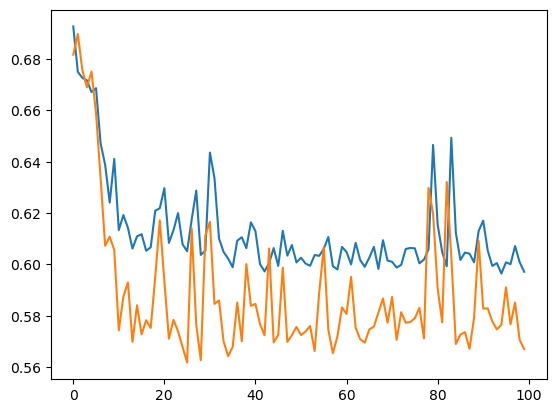

In [30]:
plt.plot(train_loss4)
plt.plot(val_loss4)

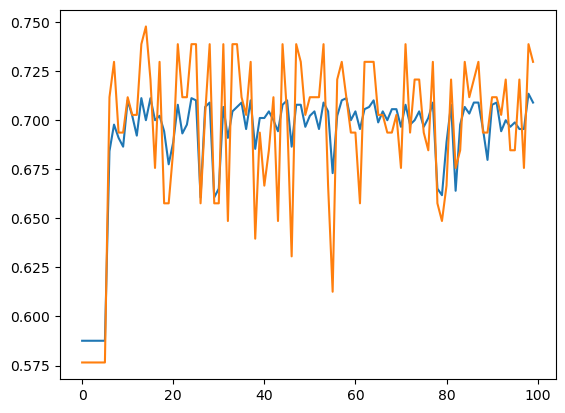

In [31]:
plt.plot(train_acc4)
plt.plot(val_acc4)

In [39]:
test_data = next(iter(test_loader)).to(device)
#print(test_data.x)
cos = model4.cosine_forward(test_data)

AttributeError: module 'torch' has no attribute 'eval'

In [41]:
torch.save(model4.state_dict(), 'oversmooth.pt')

In [57]:
model = GCN(layer4).to(device)
model.load_state_dict(torch.load('oversmooth.pt'))

C:\Users\umang\AppData\Local\Temp\ipykernel_16460\1193055240.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('oversmooth.pt'))


<All keys matched successfully>

In [59]:
cos = model.cosine_forward(test_data)

In [63]:
cos

[0.7077411413192749,
 0.7240153551101685,
 0.6426138877868652,
 0.5384620428085327,
 0.6331372857093811,
 0.691757082939148,
 0.7185124754905701,
 0.725325345993042,
 0.732323169708252,
 0.7434601783752441,
 0.7294954061508179,
 0.7283973693847656,
 0.73023921251297,
 0.7203985452651978,
 0.7129426002502441]

In [65]:
node_features = dataset.num_node_features
layers = [dataset.num_node_features, 256]
layer5 = [node_features, 32]
layer6 = [node_features, 64]
layer7 = [node_features, 128]
layer8 = [node_features, 256]


In [67]:
model5 = GCN(layer5).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=0.001, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = torch.nn.BCEWithLogitsLoss()
train_loss5, val_loss5, train_acc5, val_acc5 = train_model(model5)

Epoch 01 | Train Loss: 0.6902 | Val Loss: 0.6860 | Train Acc: 0.5888 | Val Acc: 0.5766
Epoch 02 | Train Loss: 0.6825 | Val Loss: 0.6814 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 03 | Train Loss: 0.6774 | Val Loss: 0.6791 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 04 | Train Loss: 0.6745 | Val Loss: 0.6778 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 05 | Train Loss: 0.6727 | Val Loss: 0.6768 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 06 | Train Loss: 0.6714 | Val Loss: 0.6758 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 07 | Train Loss: 0.6703 | Val Loss: 0.6749 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 08 | Train Loss: 0.6694 | Val Loss: 0.6749 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 09 | Train Loss: 0.6684 | Val Loss: 0.6732 | Train Acc: 0.6011 | Val Acc: 0.5856
Epoch 10 | Train Loss: 0.6678 | Val Loss: 0.6722 | Train Acc: 0.6045 | Val Acc: 0.5856
Epoch 11 | Train Loss: 0.6670 | Val Loss: 0.6714 | Train Acc: 0.6112 | Val Acc: 0.5766
Epoch 12 | Train Loss: 0.6669 | Val Loss: 0

In [68]:
model6 = GCN(layer6).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model6.parameters(), lr=0.001, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = torch.nn.BCEWithLogitsLoss()
train_loss6, val_loss6, train_acc6, val_acc6 = train_model(model6)

Epoch 01 | Train Loss: 0.6847 | Val Loss: 0.6826 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 02 | Train Loss: 0.6779 | Val Loss: 0.6790 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 03 | Train Loss: 0.6740 | Val Loss: 0.6773 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 04 | Train Loss: 0.6719 | Val Loss: 0.6762 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 05 | Train Loss: 0.6700 | Val Loss: 0.6744 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 06 | Train Loss: 0.6688 | Val Loss: 0.6733 | Train Acc: 0.5865 | Val Acc: 0.5766
Epoch 07 | Train Loss: 0.6672 | Val Loss: 0.6717 | Train Acc: 0.6067 | Val Acc: 0.5856
Epoch 08 | Train Loss: 0.6663 | Val Loss: 0.6704 | Train Acc: 0.6146 | Val Acc: 0.5766
Epoch 09 | Train Loss: 0.6658 | Val Loss: 0.6698 | Train Acc: 0.6146 | Val Acc: 0.5766
Epoch 10 | Train Loss: 0.6636 | Val Loss: 0.6675 | Train Acc: 0.6225 | Val Acc: 0.5946
Epoch 11 | Train Loss: 0.6627 | Val Loss: 0.6665 | Train Acc: 0.6247 | Val Acc: 0.5946
Epoch 12 | Train Loss: 0.6618 | Val Loss: 0

In [70]:
model7 = GCN(layer7).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model7.parameters(), lr=0.001, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = torch.nn.BCEWithLogitsLoss()
train_loss7, val_loss7, train_acc7, val_acc7 = train_model(model7)

Epoch 01 | Train Loss: 0.6881 | Val Loss: 0.6826 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 02 | Train Loss: 0.6765 | Val Loss: 0.6785 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 03 | Train Loss: 0.6721 | Val Loss: 0.6767 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 04 | Train Loss: 0.6710 | Val Loss: 0.6754 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 05 | Train Loss: 0.6690 | Val Loss: 0.6723 | Train Acc: 0.6034 | Val Acc: 0.5856
Epoch 06 | Train Loss: 0.6675 | Val Loss: 0.6701 | Train Acc: 0.6202 | Val Acc: 0.5946
Epoch 07 | Train Loss: 0.6660 | Val Loss: 0.6703 | Train Acc: 0.6146 | Val Acc: 0.5766
Epoch 08 | Train Loss: 0.6647 | Val Loss: 0.6690 | Train Acc: 0.6157 | Val Acc: 0.5856
Epoch 09 | Train Loss: 0.6639 | Val Loss: 0.6656 | Train Acc: 0.6326 | Val Acc: 0.6036
Epoch 10 | Train Loss: 0.6625 | Val Loss: 0.6654 | Train Acc: 0.6281 | Val Acc: 0.6036
Epoch 11 | Train Loss: 0.6601 | Val Loss: 0.6632 | Train Acc: 0.6303 | Val Acc: 0.6036
Epoch 12 | Train Loss: 0.6601 | Val Loss: 0

In [81]:
model8 = GCN(layer8).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model8.parameters(), lr=0.001, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = torch.nn.BCEWithLogitsLoss()
train_loss8, val_loss8, train_acc8, val_acc8 = train_model(model8)

Epoch 01 | Train Loss: 0.6826 | Val Loss: 0.6789 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 02 | Train Loss: 0.6732 | Val Loss: 0.6773 | Train Acc: 0.5876 | Val Acc: 0.5766
Epoch 03 | Train Loss: 0.6700 | Val Loss: 0.6724 | Train Acc: 0.6022 | Val Acc: 0.5856
Epoch 04 | Train Loss: 0.6673 | Val Loss: 0.6717 | Train Acc: 0.6034 | Val Acc: 0.5856
Epoch 05 | Train Loss: 0.6644 | Val Loss: 0.6673 | Train Acc: 0.6247 | Val Acc: 0.5946
Epoch 06 | Train Loss: 0.6629 | Val Loss: 0.6653 | Train Acc: 0.6281 | Val Acc: 0.6036
Epoch 07 | Train Loss: 0.6605 | Val Loss: 0.6631 | Train Acc: 0.6337 | Val Acc: 0.6036
Epoch 08 | Train Loss: 0.6589 | Val Loss: 0.6608 | Train Acc: 0.6348 | Val Acc: 0.6036
Epoch 09 | Train Loss: 0.6567 | Val Loss: 0.6585 | Train Acc: 0.6404 | Val Acc: 0.6036
Epoch 10 | Train Loss: 0.6564 | Val Loss: 0.6558 | Train Acc: 0.6427 | Val Acc: 0.6036
Epoch 11 | Train Loss: 0.6517 | Val Loss: 0.6524 | Train Acc: 0.6539 | Val Acc: 0.6216
Epoch 12 | Train Loss: 0.6508 | Val Loss: 0

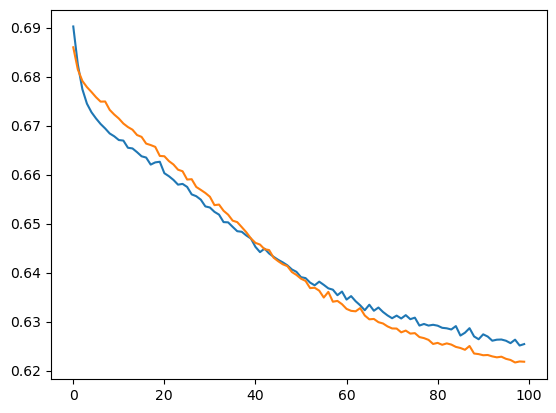

In [83]:
plt.plot(train_loss5)
plt.plot(val_loss5)

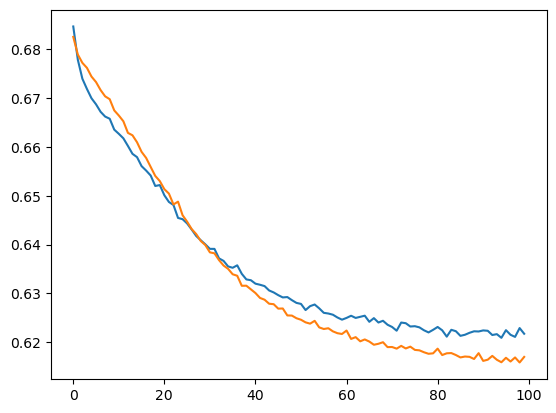

In [85]:
plt.plot(train_loss6)
plt.plot(val_loss6)

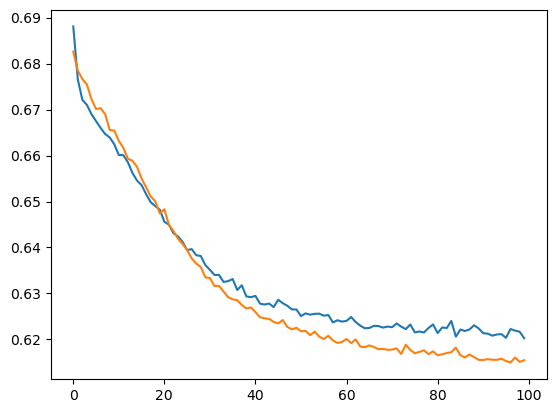

In [87]:
plt.plot(train_loss7)
plt.plot(val_loss7)

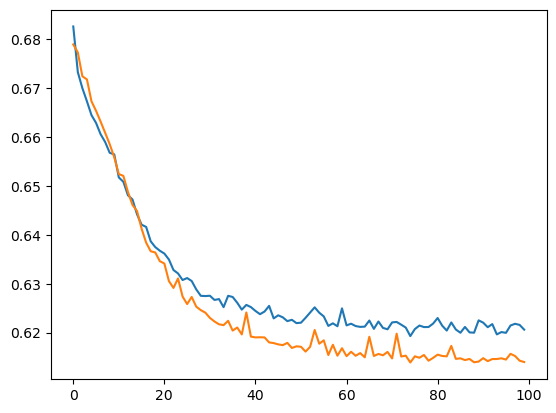

In [89]:
plt.plot(train_loss8)
plt.plot(val_loss8)

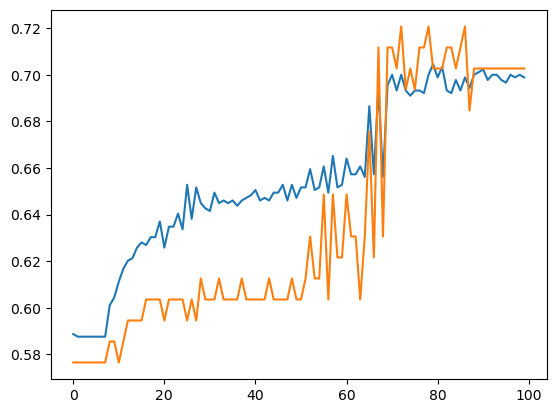

In [91]:
plt.plot(train_acc5)
plt.plot(val_acc5)

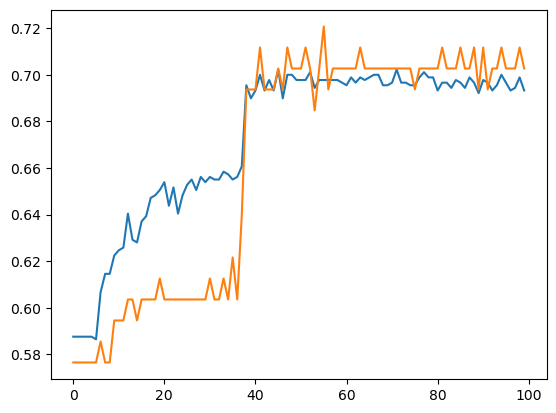

In [93]:
plt.plot(train_acc6)
plt.plot(val_acc6)

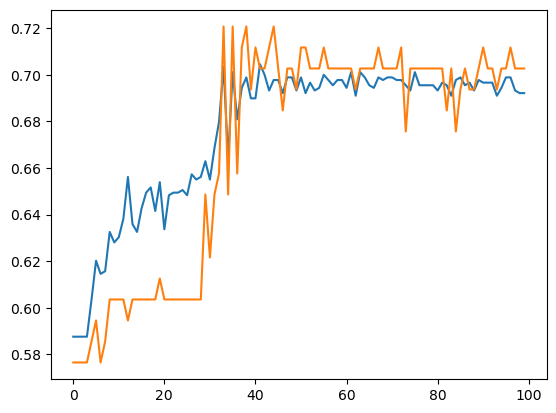

In [95]:
plt.plot(train_acc7)
plt.plot(val_acc7)

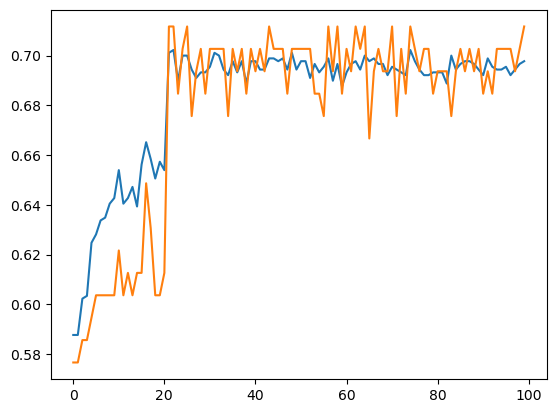

In [97]:
plt.plot(train_acc8)
plt.plot(val_acc8)